<a href="https://colab.research.google.com/github/9-coding/ComputerVision_TeamProject/blob/main/ActiveLerning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
# 각자 환경에서 이 부분만 변경하여 사용하면 됩니다.
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/Computer_Vision/ActiveLearning/CUB_200_2011_repackage_class50')
print(os.getcwd())


/content/gdrive/MyDrive/Colab Notebooks/Computer_Vision/ActiveLearning/CUB_200_2011_repackage_class50


In [3]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 19.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=bb89131127bdb23d9b78abb18f85fce13eb4b2cdafa19fa26dd98239f3496a4f
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from google.colab.patches import cv2_imshow
from PIL import Image

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

### Custom Dataset ###
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.transform = transform
    self.mode = mode

    if self.mode == 'train':
      self.image_folder = os.listdir('./datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('./datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('./datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path= self.image_folder[idx]
    img = Image.open(os.path.join('./datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)
    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)

### Data Preprocessing ###
transforms_train = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor()])
transforms_valtest = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

BATCH_SIZE = 32
train_set = CUB2011(mode='train', transform=transforms_train)
val_set = CUB2011(mode= 'valid', transform=transforms_valtest)
test_set = CUB2011(mode='test', transform=transforms_valtest)
print('Num of each dataset:', len(train_set), len(val_set), len(test_set))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader (val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader (test_set, batch_size=BATCH_SIZE, shuffle=False)

print("Loaded dataloader")

### Model / Optimzier ###
EPOCH = 30
lr = 0.1
model = models.resnet18(pretrained=True)

### Transfer Learning ###
num_features = model.fc.in_features
model.fc = nn. Linear(num_features, 50)
model.to(DEVICE)
optimizer = optim.SGD (model.parameters(), lr=lr)
print("Created a learning model and optimizer")


### Train/Evaluation ###
def train(model, train_loader, optimizer, epoch):
  model.train()
  for i, (image, target) in enumerate(train_loader):
    image, target = image.to(DEVICE), target.to(DEVICE)
    output = model(image)
    optimizer.zero_grad()
    train_loss = F.cross_entropy(output, target).to(DEVICE)

    train_loss.backward()
    optimizer.step()

    if i % 10 == 0:
      print(f'Train Epoch {epoch} [{i}/{len(train_loader)}]\tLoss: {train_loss.item():.6f}')
  return train_loss

def evaluate(model, val_loader):
  model.eval()
  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i, (image, target) in enumerate (val_loader):
      image, target = image.to(DEVICE), target.to(DEVICE)
      output = model(image)
      eval_loss += F.cross_entropy (output, target, reduction='sum').item()
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as (pred)).sum().item()
    eval_loss /= len(val_loader.dataset)
    eval_accuracy = 100 * correct / len(val_loader.dataset)
    return eval_loss, eval_accuracy

### Main ###
start = time.time()
best = 0
for epoch in range(EPOCH):
  train_loss = train(model, train_loader, optimizer, epoch)
  val_loss, val_accuracy = evaluate(model, val_loader)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(), "./best_model.pth")
  print(f'[{epoch}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}%')

# Test result
test_loss, test_accuracy = evaluate(model, test_loader)
print(f'[FINAL] Test Loss {test_loss:.4f}, Accuracy: {test_accuracy:.4f}%')
end = time.time()
elasped_time = end - start

print("Best Accuracy: ", best)
print(f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(f"time: {int (elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

cuda
Num of each dataset: 2360 296 298
Loaded dataloader


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Created a learning model and optimizer
Train Epoch 0 [0/74]	Loss: 4.015807
Train Epoch 0 [10/74]	Loss: 3.979692
Train Epoch 0 [20/74]	Loss: 2.941616
Train Epoch 0 [30/74]	Loss: 2.641432
Train Epoch 0 [40/74]	Loss: 2.051238
Train Epoch 0 [50/74]	Loss: 1.458785
Train Epoch 0 [60/74]	Loss: 1.524730
Train Epoch 0 [70/74]	Loss: 1.576972
[0] Validation Loss: 1.7091, Accuracy: 55.0676%
Train Epoch 1 [0/74]	Loss: 1.130289
Train Epoch 1 [10/74]	Loss: 0.911949
Train Epoch 1 [20/74]	Loss: 0.702102
Train Epoch 1 [30/74]	Loss: 0.670044
Train Epoch 1 [40/74]	Loss: 0.519873
Train Epoch 1 [50/74]	Loss: 0.544592
Train Epoch 1 [60/74]	Loss: 0.642091
Train Epoch 1 [70/74]	Loss: 0.474168
[1] Validation Loss: 0.7710, Accuracy: 79.3919%
Train Epoch 2 [0/74]	Loss: 0.194759
Train Epoch 2 [10/74]	Loss: 0.199819
Train Epoch 2 [20/74]	Loss: 0.159109
Train Epoch 2 [30/74]	Loss: 0.258504
Train Epoch 2 [40/74]	Loss: 0.234837
Train Epoch 2 [50/74]	Loss: 0.079568
Train Epoch 2 [60/74]	Loss: 0.195997
Train Epoch 2 [70

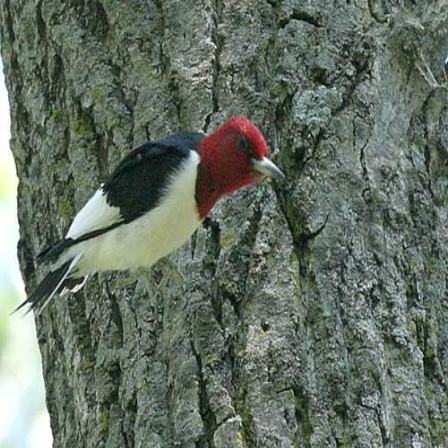

In [6]:
# Assuming train_set is an instance of your CUB2011 Dataset class
image_tensor, label = train_set[0]  # Fetching an image and its label

# Convert tensor to numpy array
image_np = image_tensor.permute(1, 2, 0).numpy()  # Convert tensor to NumPy array
image_np = (image_np * 255).astype(np.uint8)  # Scale to 0-255 and change data type to uint8

# Convert RGB to BGR (as cv2 uses BGR format)
image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

# Display the image using cv2_imshow
cv2_imshow(image_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()
